In [3]:
#chack for updated files\n,
%load_ext autoreload
%autoreload 2
#import packages
from __future__ import division

import numpy as np
import glob, json
import pickle
import os as os_pack
import matplotlib.pyplot as plt
import corner
#%matplotlib inline\n",
%config InlineBackend.figure_format = 'retina'
import healpy as hp
import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
from enterprise_extensions import blocks
from enterprise_extensions import models as ee_models
from enterprise_extensions import model_utils as ee_model_utils
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise_extensions import sampler as ee_sampler
from enterprise.signals.signal_base import LogLikelihood
import enterprise_wavelets as models
from enterprise.signals.deterministic_signals import Deterministic
from enterprise.signals.parameter import function
from la_forge.core import Core
from la_forge.diagnostics import plot_chains
from la_forge import rednoise
import la_forge
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import re
#style
    
#import Fast_Burst_likelihood as FB

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#Loading in pickle and noise files
pint_pickle = '/home/reyna/OS_15yr/15yr_data/v1p1_de440_pint_bipm2019.pkl'
noise_file = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file, 'r') as h:
    noise_params = json.load(h)
with open(pint_pickle,'rb') as f:
    allpsrs = pickle.load(f)
psrs = []
for ii,p in enumerate(allpsrs):
    psrs.append(p)
#Temporary to get code to not crash
psrs = psrs[0:8]
psrlist = [psr.name for psr in psrs]
print(psrlist)
for i in range(len(psrs)):
    print((max(psrs[i].toas) - min(psrs[i].toas))/(3.17*10**(7)))

['B1855+09', 'B1937+21', 'B1953+29', 'J0023+0923', 'J0030+0451', 'J0340+4130', 'J0406+3039', 'J0437-4715']
15.515060297068947
15.802872967471835
11.08458774068679
8.97542529762611
15.460752938661816
8.097196263848735
3.5471797714338695
4.73231500896138


In [5]:
parDir =  '/home/reyna/BayesHopperBurst/QuickBurst/Single_Transient_Simulated_Data/pars/'
timDir =  '/home/reyna/BayesHopperBurst/QuickBurst/Single_Transient_Simulated_Data/tims/'
psrlist = sorted(glob.glob(parDir+'*.par'))
for _ in range(len(psrlist)):
    psrlist[_] = re.sub(parDir, '', psrlist[_])
    psrlist[_] = re.sub('_NANOGrav_12yv2.gls.par', '', psrlist[_])
parfiles = sorted(glob.glob(parDir+'*.par'))
timfiles = sorted(glob.glob(timDir+'*.tim'))
psrs_sim = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=None, clk=None)
    psrs_sim.append(psr)

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [6]:
#Loading in pickle and noise files
noise_file_sim = '/home/reyna/OS_15yr/15yr_data/v1p1_wn_dict.json'
#psrlist = np.loadtxt('/home/reyna/15yr_v1p0/15yr_v1-20211001T235643Z-001/15yr_v1/psrlist_15yr_pint.txt', dtype = str)
with open(noise_file_sim, 'r') as h:
    noise_params_sim = json.load(h)
#Temporary to get code to not crash
psrs_sim = psrs_sim[0:8]
psrlist = [psr.name for psr in psrs_sim]
print(psrlist)
for i in range(len(psrs_sim)):
    print((max(psrs_sim[i].toas) - min(psrs_sim[i].toas))/(3.17*10**(7)))

['JPSR00', 'JPSR01', 'JPSR02', 'JPSR03', 'JPSR04', 'JPSR05', 'JPSR06', 'JPSR07']
9.893753204746307
9.893759921988087
9.893754816178342
9.893759889756392
9.893756654153247
9.89375896654812
9.89374832210285
9.893748096020424


In [7]:
glitches = []
log10_f0 = parameter.Uniform(np.log10(3.5e-9), np.log10(1e-7))("Glitch_"+str(1)+'_'+'log10_f0')
phase0 = parameter.Uniform(0, 2*np.pi)("Glitch_"+str(1)+'_'+'phase0')
tau = parameter.Uniform(0.2, 5)("Glitch_"+str(1)+'_'+'tau')
t0 = parameter.Uniform(0.0, 10.0)("Glitch_"+str(1)+'_'+'t0')
psr_idx = parameter.Uniform(-0.5, len(psrs)-0.5)("Glitch_"+str(1)+'_'+'psr_idx')
log10_h = parameter.LinearExp(-6.5, -5)("Glitch_"+str(1)+'_'+'log10_h')
glitch_wf = models.glitch_delay(log10_h = log10_h, tau = tau, log10_f0 = log10_f0, t0 = t0, phase0 = phase0, tref=53000*86400,
                                        psr_float_idx = psr_idx, pulsars=psrs)
glitches.append(deterministic_signals.Deterministic(glitch_wf, name='Glitch'+str(1) ))

In [8]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches[0]
model = []
for p in psrs:
    model.append(s(p))
with open(noise_file, 'r') as fp:
    noisedict = json.load(fp)
    pta = signal_base.PTA(model)
    pta.set_default_params(noisedict)

In [9]:
tm = gp_signals.TimingModel(use_svd=True)
wn = blocks.white_noise_block(vary=False, inc_ecorr=False)
#s = base_model
s = tm + wn + glitches[0]
model = []
for p in psrs_sim:
    model.append(s(p))
with open(noise_file_sim, 'r') as fp:
    noisedict = json.load(fp)
    pta_sim = signal_base.PTA(model)
    pta_sim.set_default_params(noisedict)

JPSR00_efac not set! Check parameter dict.
JPSR00_log10_t2equad not set! Check parameter dict.
JPSR01_efac not set! Check parameter dict.
JPSR01_log10_t2equad not set! Check parameter dict.
JPSR02_efac not set! Check parameter dict.
JPSR02_log10_t2equad not set! Check parameter dict.
JPSR03_efac not set! Check parameter dict.
JPSR03_log10_t2equad not set! Check parameter dict.
JPSR04_efac not set! Check parameter dict.
JPSR04_log10_t2equad not set! Check parameter dict.
JPSR05_efac not set! Check parameter dict.
JPSR05_log10_t2equad not set! Check parameter dict.
JPSR06_efac not set! Check parameter dict.
JPSR06_log10_t2equad not set! Check parameter dict.
JPSR07_efac not set! Check parameter dict.
JPSR07_log10_t2equad not set! Check parameter dict.


In [23]:
d0 = parameter.sample(pta.params)
x0 = np.array([d0[par.name] for par in pta.params])

In [11]:
d0 = {
    'Glitch_1_log10_f0':np.log10(6e-8),
    'Glitch_1_log10_h':np.log10(1e-5), #medium amp
#    'Glitch_1_log10_h':np.log10(2e-6), #low amp
#    'Glitch_1_log10_h':np.log10(1e-6), #very low amp
    'Glitch_1_phase0':1.0,
    'Glitch_1_psr_idx':0.0,
    'Glitch_1_t0':2500.0/365.25, #year
    'Glitch_1_tau':300.0/365.25, #year
}
x0 = np.array([d0[par.name] for par in pta.params])

In [12]:
pta.get_lnlikelihood(x0)

729888.6062270588

In [13]:
#low amp
731570.2660273536
731534.327856984
731457.1680885213

731457.1680885213

In [14]:
731057.5081932246
730725.4576540552
730115.9375572067

730115.9375572067

In [15]:
d0

{'Glitch_1_log10_f0': -7.221848749616356,
 'Glitch_1_log10_h': -5.0,
 'Glitch_1_phase0': 1.0,
 'Glitch_1_psr_idx': 0.0,
 'Glitch_1_t0': 6.844626967830253,
 'Glitch_1_tau': 0.8213552361396304}

In [19]:
import Fast_Burst_likelihood as FB

In [20]:
FB1 = FB.FastBurst(pta = pta, psrs = psrs, params = d0, Npsr = len(psrs), tref=53000*86400)
#FB2 = FB.FastBurst(pta = pta, psrs = psrs, params = d0, Npsr = len(psrs), tref=53000*86400)

Nvecs arary:  [[1.69852389e-12 1.12772641e-10 3.26328092e-12 ... 4.85655692e-12
 5.14669141e-13 1.79238956e-12], [6.95185145e-14 1.57784257e-13 2.75345324e-14 ... 1.37317696e-13
 6.53510393e-13 3.42658995e-13], [4.94236756e-10 4.03404993e-10 7.90600715e-10 ... 2.03923984e-10
 4.69194849e-10 4.02505715e-10], [1.78150121e-13 6.22555077e-13 1.41224754e-13 ... 4.44123286e-11
 2.71409648e-11 3.12885720e-11], [4.61695300e-12 5.66353407e-11 6.83697178e-12 ... 9.39287544e-12
 1.01635764e-11 6.60318228e-12], [3.58685902e-11 2.77047195e-11 8.77407399e-11 ... 4.00248661e-11
 7.61997117e-11 4.82576810e-11], [2.30848299e-11 2.25095542e-12 6.90732193e-12 ... 1.26507575e-11
 3.65281122e-11 1.93290456e-11], [5.49729188e-12 4.98164427e-12 5.77752577e-12 ... 4.40088221e-12
 4.86261323e-12 1.46668814e-09], ...]
-23682983.175477527
logdet_phi:  15289.165017480458
logdet_sigma:  4448.603620972838
dotSigmaTNr:  6171.411084360541
logdet_phi:  25604.746234093782
logdet_sigma:  8639.86438247935
dotSigmaTNr:  4

In [21]:
FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]), (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3])

Amplitude:  1e-05
Frequency:  6.000000000000003e-08
glitch_index:  0.0
Old Sigma:  [0. 0.]
New sigma:  [ 5.40302306e-06 -8.41470985e-06]
Old M and N:  [[0. 0.]
 [0. 0.]] [0. 0.]
Input time:  2495.4369153547796
Cosine:  [ 6.85184313e-23  6.85184313e-23  6.85184313e-23 ... -5.33351854e-62
 -5.33351854e-62 -5.33351854e-62]
Sine:  [-3.58505989e-23 -3.58505989e-23 -3.58505989e-23 ...  2.39112110e-62
  2.39112110e-62  2.39112110e-62]
33637693320383.77
3845814950046.457
3845814950046.4624
22666262917510.117
MM matrix: [[[3.36376933e+13 3.84581495e+12]
  [3.84581495e+12 2.26662629e+13]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e

727065.2626002779

In [ ]:
%%time
NN = 50

log_L_olds = []
log_L_news = []

for i in range(NN):
    d0 = parameter.sample(pta.params)
    x0 = np.array([d0[par.name] for par in pta.params])
    
    log_L_olds.append(pta.get_lnlikelihood(x0))
    log_L_news.append(FB1.get_lnlikelihood(10**(x0[1]), x0[2], 10**(x0[0]),
                                           (3.15*10**7)*x0[5], (3.15*10**7)*x0[4], x0[3]))

log_L_olds = np.array(log_L_olds)
log_L_news = np.array(log_L_news)

In [ ]:
plt.plot(log_L_olds, log_L_news, ls='', marker='.', color='xkcd:blue')
plt.plot(log_L_olds, log_L_olds, ls='--', color='xkcd:green')
plt.xlabel("enterprise log(likelihood)")
plt.ylabel("QuickBurst log(likelihood)")

In [ ]:
plt.plot(log_L_olds, log_L_news-log_L_olds, ls='', marker='.', color='xkcd:blue')
plt.gca().axhline(0.1, ls='--', color='xkcd:green')
plt.xlabel("enterprise log(likelihood)")
plt.ylabel("delta log(likelihood)")
plt.yscale('log')

[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]
[ 5.40302306e-06 -8.41470985e-06]


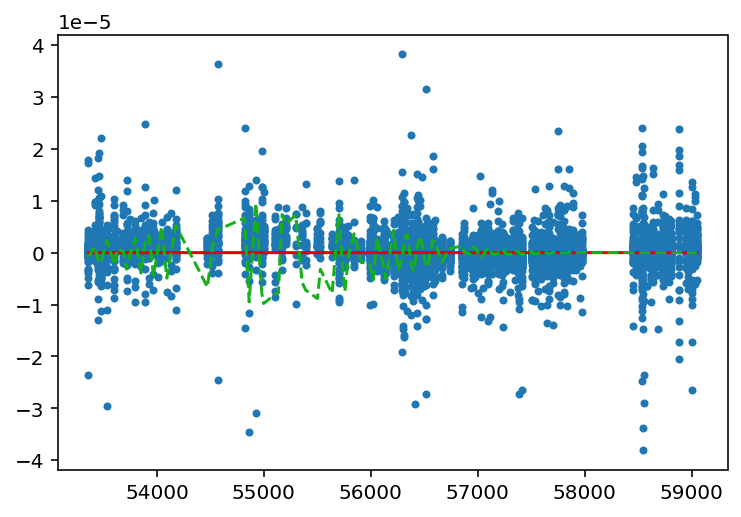

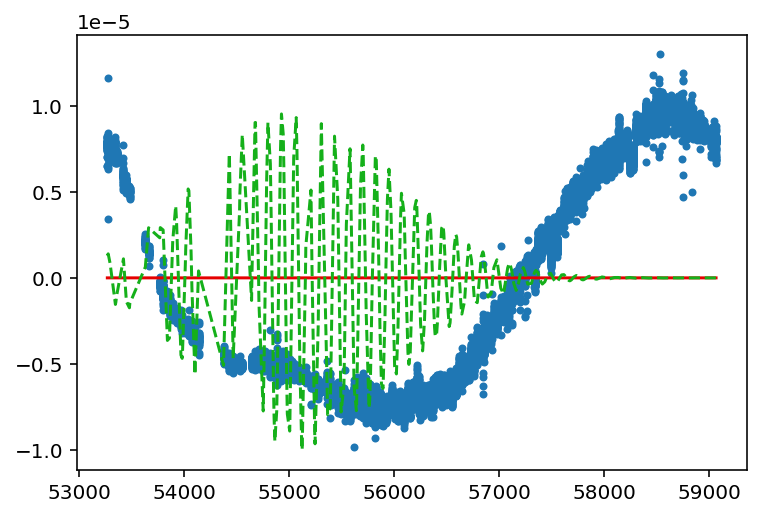

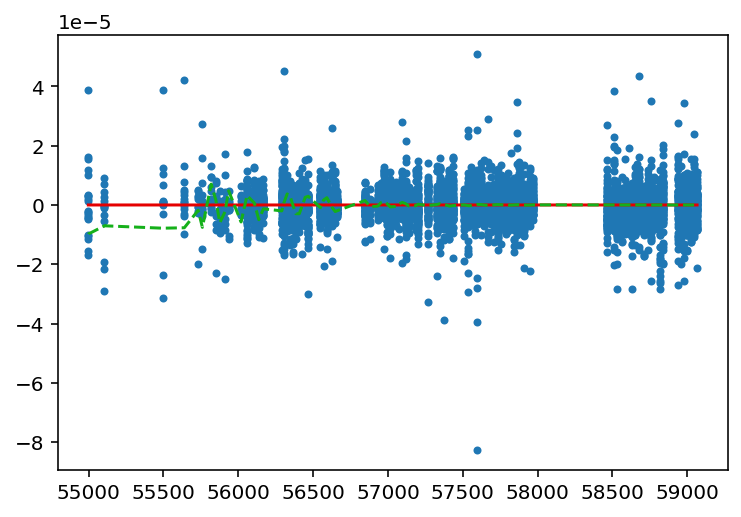

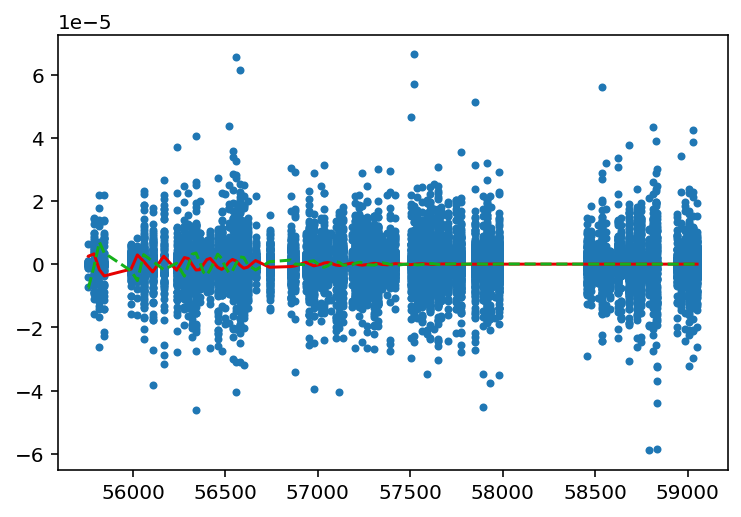

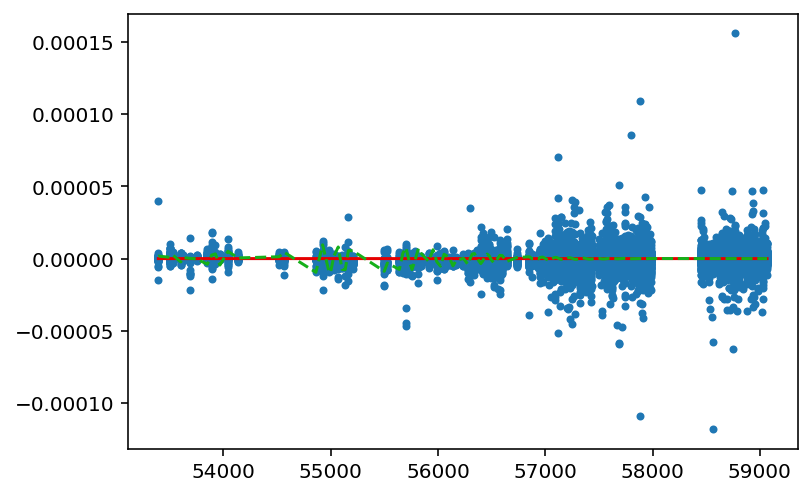

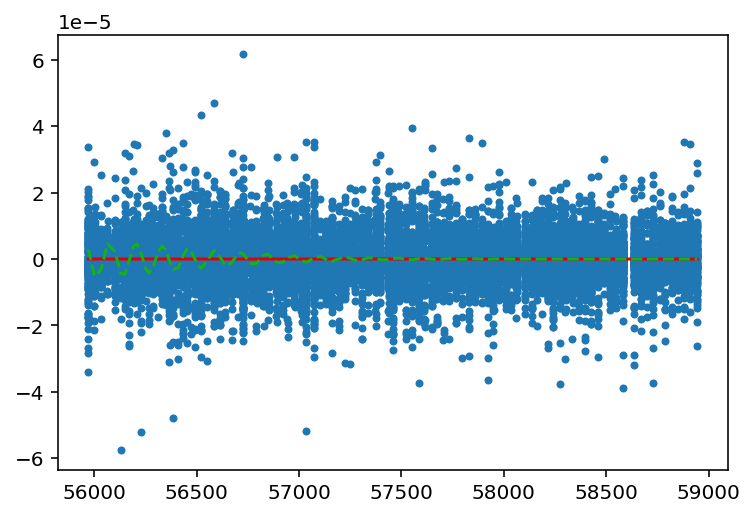

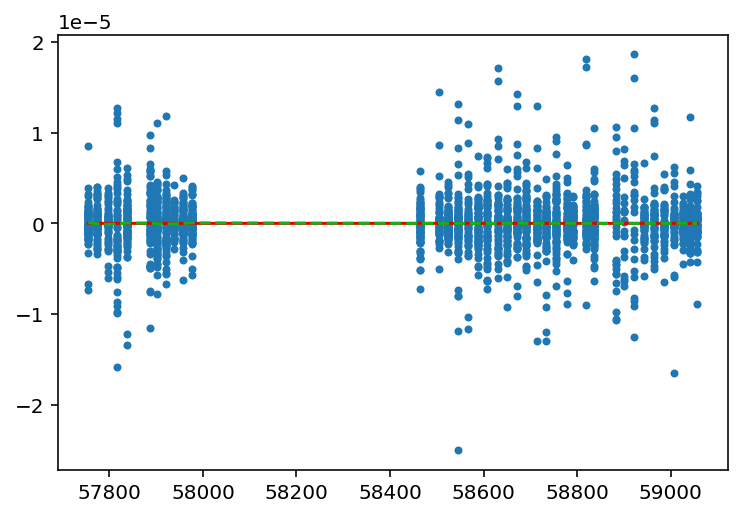

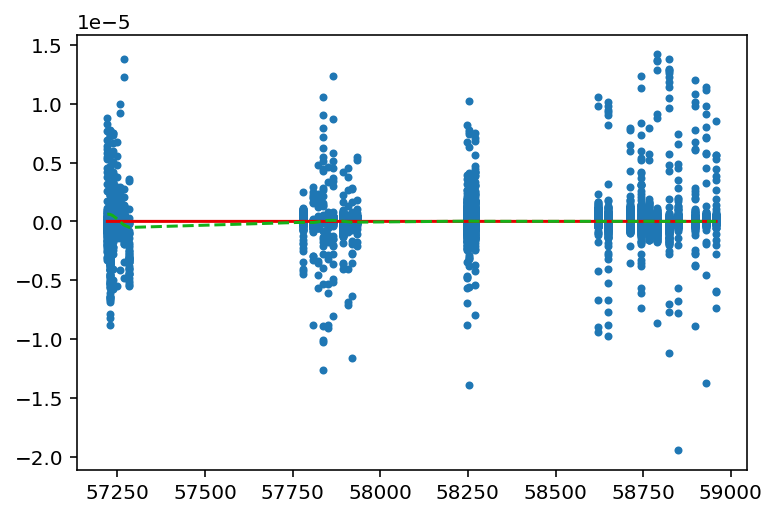

In [24]:
for i, psr in enumerate(psrs):
    plt.figure(i)
    plt.plot(psr.toas/86400, psr.residuals, ls='', marker='.')
    plt.plot(psr.toas/86400, pta.get_delay(d0)[i],color='xkcd:red')
    
    f0 = 10**(x0[0])
    tau = (3.15*10**7)*x0[5]
    t0 = (3.15*10**7)*x0[4]
    
    Cosine = np.exp(-1*((FB1.toas[i] - t0)/tau)**2)*np.cos(2*np.pi*f0*(FB1.toas[i] - t0))
    Sine = np.exp(-1*((FB1.toas[i] - t0)/tau)**2)*np.sin(2*np.pi*f0*(FB1.toas[i] - t0))
    print(FB1.sigma)
    fast_delay = FB1.sigma[0]*Cosine + FB1.sigma[1]*Sine
    plt.plot(psr.toas/86400, fast_delay, ls='--',color='xkcd:green')